In [2]:
import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import optimize
from scipy.signal import find_peaks, peak_widths, savgol_filter, convolve, peak_prominences
from scipy.fft import *
# from scipy.fftpack import *
import peakutils
from peakutils.plot import plot as pplot

In [3]:
folder ='Affinity Data/AAVA3/'
CSVs = glob.glob(f'{folder}/*.csv')


In [5]:
data = pd.read_csv(CSVs[13], delimiter='\t', encoding='utf_16', skiprows=[0,1], low_memory=False)

In [20]:
CSVs[13]

'Affinity Data/AAVA3/AAVA3_AAV10 HEK lysate 002.csv'

In [ ]:
['Elution pH',
'Wash pH',
'Equlibration pH',
'Elution Conductivity',
'Wash Conductivity',
'Equilibration Conductivity']

In [7]:
data.columns

Index(['ml', 'mAU', 'ml.1', 'mS/cm', 'ml.2', 'mAU.1', 'ml.3', 'pH', 'ml.4',
       'Injection', 'ml.5', 'Logbook', 'ml.6', 'Fraction', 'ml.7', '%', 'ml.8',
       'mAU.2', 'ml.9', 'MPa', 'ml.10', 'MPa.1', 'ml.11', 'MPa.2', 'ml.12',
       'MPa.3', 'ml.13', 'MPa.4', 'ml.14', 'ml/min', 'ml.15', 'cm/h', 'ml.16',
       'ml/min.1', 'ml.17', 'cm/h.1', 'ml.18', 'cm', 'ml.19', 'CV/h', 'ml.20',
       'CV/h.1', 'ml.21', '%.1', 'ml.22', '°C', 'ml.23', '°C.1'],
      dtype='object')

In [30]:
round(data['ml.3'])

0       -10.0
1       -10.0
2       -10.0
3       -10.0
4       -10.0
         ... 
52545     NaN
52546     NaN
52547     NaN
52548     NaN
52549     NaN
Name: ml.3, Length: 52550, dtype: float64

In [8]:
data[['ml.3', 'pH']]


,ml.3,pH
0,-10.028101,0.000000
1,-10.022002,6.039771
2,-10.015903,6.058799
3,-10.009806,6.059083
4,-10.003707,6.058880
...,...,...
52545,NaN,NaN
52546,NaN,NaN
52547,NaN,NaN
52548,NaN,NaN


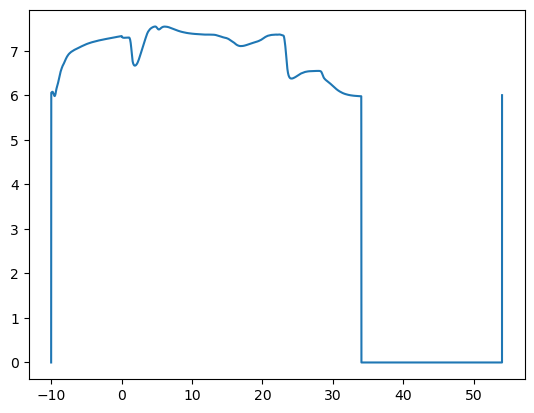

In [21]:
plt.plot(data['ml.3'], data['pH'])

In [54]:
elution_ph_index = data['ml.3'][round(data['ml.3']) == round(data['ml.5'][4])].index[30]
elution_cond_index = data['ml.1'][round(data['ml.1']) == round(data['ml.5'][4])].index[30]
wash_ph_index = data['ml.3'][round(data['ml.3']) == round(data['ml.5'][3])].index[30]
wash_cond_index = data['ml.1'][round(data['ml.1']) == round(data['ml.5'][3])].index[30]
equilibration_ph_index = data['ml.3'][round(data['ml.3']) == round(data['ml.5'][1])].index[30]
equilibration_cond_index = data['ml.1'][round(data['ml.1']) == round(data['ml.5'][1])].index[30]


elution_ph = round(data['pH'][elution_ph_index], 2)
elution_cond = round(data['mS/cm'][elution_cond_index], 2)

wash_ph = round(data['pH'][wash_ph_index], 2)
wash_cond = round(data['mS/cm'][wash_cond_index], 2)

equilibration_ph = round(data['pH'][equilibration_ph_index], 2)
equilibration_cond = round(data['pH'][equilibration_cond_index], 2)

In [ ]:
Elution pH: 7.36, Elution Conductivity: 3.18
Wash pH: 7.37, Wash Conductivity: 2.91
Equilibration pH: 6.08, Equilibration Conductivity: 6.08


Elution pH: 7.36, Elution Conductivity: 3.18
Wash pH: 7.36, Wash Conductivity: 2.91
Equilibration pH: 6.05, Equilibration Conductivity: 6.05

Elution pH: 7.37, Elution Conductivity: 3.18
Wash pH: 7.36, Wash Conductivity: 2.91
Equilibration pH: 5.98, Equilibration Conductivity: 5.98

In [55]:
print(f'Elution pH: {elution_ph}, Elution Conductivity: {elution_cond}')
print(f'Wash pH: {wash_ph}, Wash Conductivity: {wash_cond}')
print(f'Equilibration pH: {equilibration_ph}, Equilibration Conductivity: {equilibration_cond}')

Elution pH: 7.36, Elution Conductivity: 3.18
Wash pH: 7.37, Wash Conductivity: 2.91
Equilibration pH: 6.08, Equilibration Conductivity: 6.08


In [46]:
data['mS/cm'][25910]

3.182009

In [47]:
round(data['mS/cm'][25910], 2)

3.18

In [44]:
data['ml.1'][round(data['ml.1']) == round(data['ml.5'][4])].index[50]

25904

In [ ]:
data['pH']

In [6]:
data[['Logbook', 'ml.5']].head(10)

,Logbook,ml.5
0,Method Settings,-10.028101
1,Equilibration,-10.028048
2,Sample Application,-0.005532
3,Column Wash,12.004667
4,Elution,22.004705
5,Column CIP,32.014685
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [96]:
data['mAU'] = data['mAU'].apply(lambda x: 0 if x < 0 else x)
data['mAU'] = data['mAU'].loc[data['ml'] > 0]
data['mAU'] = data['mAU'].loc[data['ml'] > 20]
data['mAU'].reset_index(drop=True, inplace=True)
data['mAU'].dropna(inplace=True)


In [48]:
print(data['ml'][27058])
print(data['ml'][27306])
print(data['ml'][27306] - data['ml'][27058])

22.966198
23.268616
0.30241800000000296


In [50]:
def query_line(results):
    row_0 = [i for i in results[0]]
    row_1 = [data['ml'][round(i)] for i in results[1]]
    row_2 = [data['ml'][round(i)] for i in results[2]]
    return [row_0, row_1, row_2]

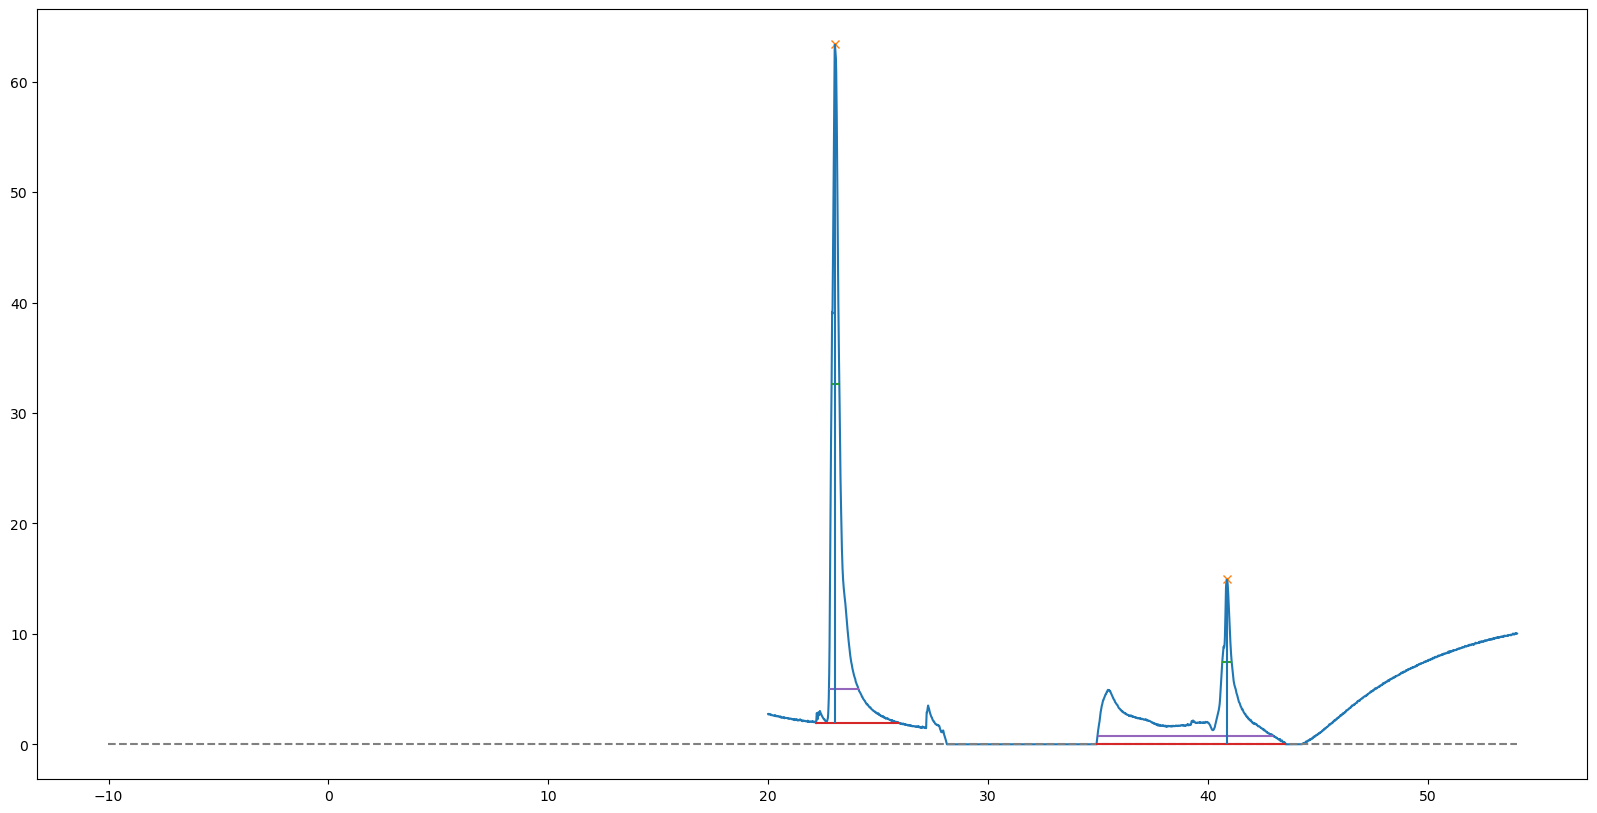

In [97]:
peaks, info = find_peaks(data['mAU'], height=12, width=25)
results_half = peak_widths(data['mAU'], peaks, rel_height=0.5)
results_full = peak_widths(data['mAU'], peaks, rel_height=1)
results_five_pec = peak_widths(data['mAU'], peaks, rel_height=0.95)
results_ten_pec = peak_widths(data['mAU'], peaks, rel_height=0.9)
prominences = peak_prominences(data['mAU'], peaks)[0]
contour_heights = data['mAU'][peaks] - prominences


half = query_line(results_half[1:])
full = query_line(results_full[1:])
ten_pec = query_line(results_ten_pec[1:])
five_pec = query_line(results_five_pec[1:])

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['ml'], data['mAU'])
plt.plot(data['ml'][peaks], data['mAU'][peaks], "x")
# plt.plot(np.zeros_like(data['mAU']), "--", color="gray")
plt.hlines(y=0, xmin=min(data['ml']), xmax=max(data['ml']), linestyle="dashed", color="gray" )
plt.hlines(*half, color="C2")
plt.hlines(*full, color="C3")
plt.hlines(*five_pec, color="C4")
# plt.hlines(*ten_pec, color="C4")
plt.vlines(x=data['ml'][peaks], ymin=contour_heights, ymax=data['mAU'][peaks])
plt.show()

In [126]:
def tailing_factor(peaks, results, height):
    res = {}
    for i in range(len(peaks)):
        a = peaks[i] - results[1][i]
        b = results[2][i] - peaks[i]
        Tf = (a+b) / (2*a)
        res[height[i]] = Tf
    return res

def symmmetry_factor(peaks, results, height):
    res = {}
    for i in range(len(peaks)):
        a = peaks[i] - results[1][i]
        b = results[2][i] - peaks[i]
        S = b / (2 * a)
        res[height[i]] = S
    return res


def peak_assymetry(peaks, results, height):
    res = {}
    for i in range(len(peaks)):
        a = peaks[i] - results[1][i]
        b = results[2][i] - peaks[i]
        res[height[i]] = b/a
    return res

def number_of_theoretical_plates(peaks, results, height):
    res = {}
    for i in range(len(peaks)):
        retention_volume = data['ml'][peaks[i]]
        #width = results[i]
        width = data['ml'][round(results[2][i])] - data['ml'][round(results[1][i])]
        N = 5.54 * (retention_volume/width)**2
        res[height[i]] = N
    return res

def area(peaks, results, height):
    res = {}
    n_plates = number_of_theoretical_plates(peaks, results, height)
    for i in range(len(peaks)):
        retention_volume = data['ml'][peaks[i]]
        H = height[i]
        N = n_plates[H]
        denominator = math.sqrt(N / (2*math.pi))
        # print(data['ml'][peaks[i]])
        area = (retention_volume * H) / denominator
        res[height[i]] = area
    return res

In [103]:
data['ml'][round(27277.3048449)] - data['ml'][round(26988.1057024)]

0.3524320000000003

In [102]:
results_half

(array([289.1991425 , 349.86218661]),
 array([32.654195 ,  7.4932275]),
 array([26988.1057024 , 41556.73356753]),
 array([27277.3048449 , 41906.59575414]))

In [ ]:
{61.495642000000004: 2.5076078605210754, 14.986455: 0.6791582051517077}
{61.495642000000004: 2.0076078605210754, 14.986455: 0.17915820515170763}
{61.495642000000004: 2.820288307258188, 14.986455: 2.7376077590844337}
{61.495642000000004: 0.035139235091620334, 14.986455: 0.0755685130726954}
23.032351
40.861336
{61.495642000000004: 22292955.02080607, 14.986455: 5702519.701900862}

In [122]:
prominences

array([61.495642, 14.986455])

In [127]:
print(tailing_factor(peaks, results_five_pec[1:], prominences))
print(symmmetry_factor(peaks, results_five_pec[1:], prominences))
print(peak_assymetry(peaks, results_ten_pec[1:], prominences))
print(number_of_theoretical_plates(peaks, results_half[1:], prominences))
print(area(peaks, results_full[1:], prominences))

{61.495642000000004: 2.5076078605210754, 14.986455: 0.6791582051517077}
{61.495642000000004: 2.0076078605210754, 14.986455: 0.17915820515170763}
{61.495642000000004: 2.820288307258188, 14.986455: 2.7376077590844337}
{61.495642000000004: 23661.13843368438, 14.986455: 50774.70410767185}
{61.495642000000004: 248.06199941439277, 14.986455: 137.4293318079233}
